# 3.4. Linear Regression Implementation from Scratch

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

### 3.4.1 Defining the Model

In [15]:
class LinearRegressionScratch(d2l.Module):
  """The linear regression model implemented from scratch."""
  def __init__(self, num_inputs, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)

In [16]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
  return torch.matmul(X, self.w) + self.b

### 3.4.2 Defining the Loss Function

In [32]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  l = (y_hat - y) ** 2 / 2
  return l.mean()

### 3.4.3 Defining the Optimization Algorithm

In [33]:
class SGD(d2l.HyperParameters):
  """Minibatch stochastic gradient descent."""
  def __init__(self, params, lr):
    self.save_hyperparameters()

  def step(self):
    for param in self.params:
        param -= self.lr * param.grad

  def zero_grad(self):
    for param in self.params:
        if param.grad is not None:
            param.grad.zero_()

In [34]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
  return SGD([self.w, self.b], self.lr)

### 3.4.4 Training

In [35]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
  return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
  self.model.train()
  for batch in self.train_dataloader:
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
          loss.backward()
          if self.gradient_clip_val > 0:  # To be discussed later
              self.clip_gradients(self.gradient_clip_val, self.model)
          self.optim.step()
      self.train_batch_idx += 1
  if self.val_dataloader is None:
      return
  self.model.eval()
  for batch in self.val_dataloader:
      with torch.no_grad():
          self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx += 1

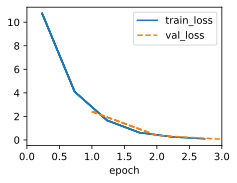

In [38]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [39]:
with torch.no_grad():
  print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
  print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1644, -0.2081])
error in estimating b: tensor([0.2329])


## Discussions & Exercises

* Defining the model: relating its input and parameters to its output. For our linear model we simply take the matrix–vector product of the input features **X** and the model weights **w**, and add the offset **b** to each example. The product **Xw** is a vector and **b** is a scalar. Because of the broadcasting mechanism, when we add a vector and a scalar, the scalar is added to each component of the vector. The resulting **forward** method is registered in the **LinearRegressionScratch** class via **add_to_class**.
* Defining the loss function: we use the squared loss function. In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following method will also have the same shape as y_hat. We also return the averaged loss value among all examples in the minibatch.
* At each step, using a minibatch randomly drawn from our dataset, we estimate the gradient of the loss with respect to the parameters. Next, we update the parameters in the direction that may reduce the loss. Since our loss is computed as an average over the minibatch, we do not need to adjust the learning rate against the batch size.
* Training: In each epoch, we iterate through the entire training dataset, passing once through every example (assuming that the number of examples is divisible by the batch size). In each iteration, we grab a minibatch of training examples, and compute its loss through the model’s training_step method. Then we compute the gradients with respect to each parameter. Finally, we will call the optimization algorithm to update the model parameters.
* In general, setting hyperparameters is tricky and we will usually want to use a three-way split, one set for training, a second for hyperparameter selection, and the third reserved for the final evaluation.
* However, in machine learning, we are often less concerned with recovering true underlying parameters, but rather with parameters that lead to highly accurate prediction. Stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate prediction.

### Exercises

1. Experiment using different learning rates to find out how quickly the loss function value drops.

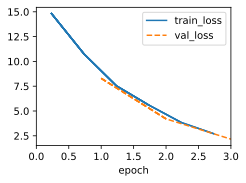

In [40]:
model = LinearRegressionScratch(2, lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

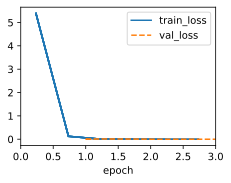

In [41]:
model = LinearRegressionScratch(2, lr=0.1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

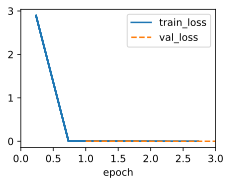

In [42]:
model = LinearRegressionScratch(2, lr=0.2)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Can you reduce the error by increasing the number of epochs of training?

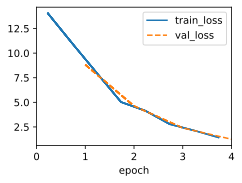

In [44]:
model = LinearRegressionScratch(2, lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=4)
trainer.fit(model, data)

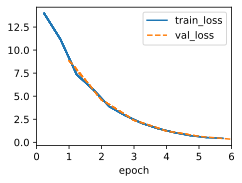

In [43]:
model = LinearRegressionScratch(2, lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=6)
trainer.fit(model, data)

2. Try implementing a different loss function, such as the absolute value loss (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum().

In [45]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
  return l

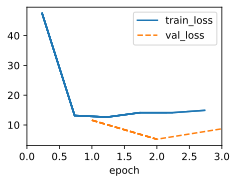

In [46]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)